In [1]:
import ast
import time
import math
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt
from numpy import arccos, arctan2
from qiskit.visualization.bloch import Bloch
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.circuit.library import RYGate, XGate
from qiskit_aer import Aer
from qiskit.primitives import Sampler

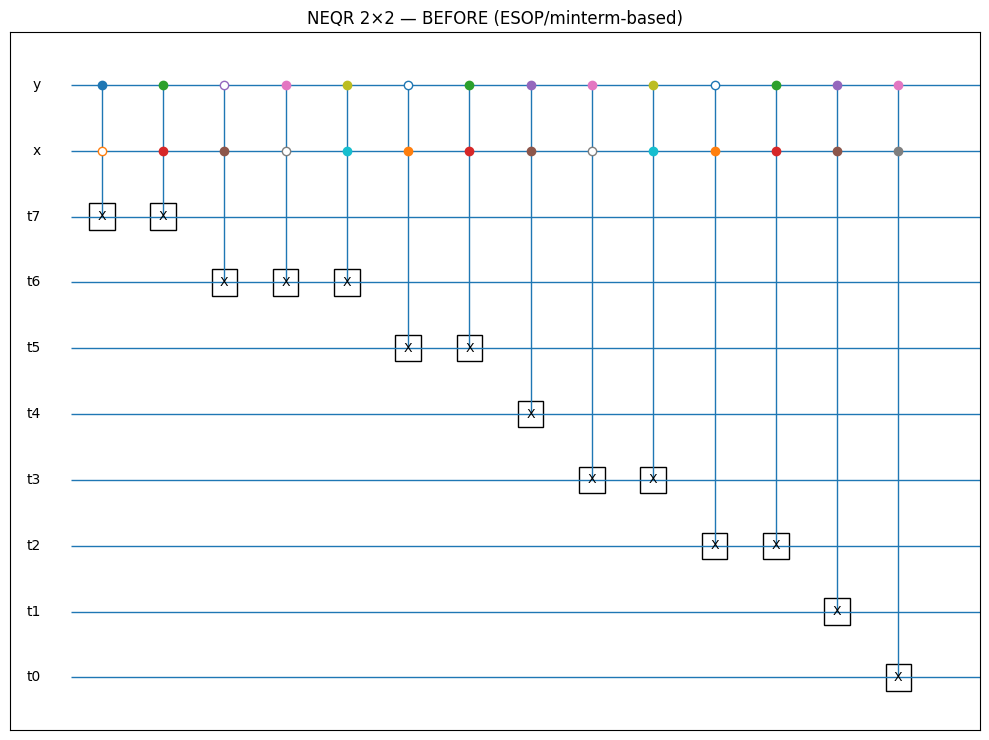

In [2]:
# BEFORE (ESOP/minterm-based) — NEQR circuit for 2×2 pixels with values [0, 100, 200, 255]
import matplotlib.pyplot as plt

# ----- Problem setup -----
# Address order (y,x): 00, 01, 10, 11
vals = [0, 100, 200, 255]
bits = [f"{v:08b}" for v in vals]           # strings b7..b0
a_by_bit = [[int(b[k]) for b in bits] for k in range(8)]  # per k=b7..b0: [f(00),f(01),f(10),f(11)]

# ----- Build ESOP minterm-based gates (may include negative controls) -----
def esop_gates_for_bit(bit_index, a):
    gates = []
    tname = f"t{bit_index}"
    # idx: 0->00, 1->01, 2->10, 3->11 (y=idx>>1, x=idx&1)
    for idx, val in enumerate(a):
        if val == 1:
            y = (idx >> 1) & 1
            x = idx & 1
            controls = [
                ('y', +1 if y == 1 else -1),  # +1: control on 1, -1: control on 0 (negative)
                ('x', +1 if x == 1 else -1),
            ]
            gates.append({'target': tname, 'controls': controls})
    return gates

wires = ['y', 'x'] + [f"t{b}" for b in range(7, -1, -1)]
before_gates = []
for k in range(7, -1, -1):                         # t7..t0 (match target order)
    a = a_by_bit[7 - k]                             # a_by_bit[0] corresponds to b7
    before_gates.extend(esop_gates_for_bit(k, a))

# ----- Simple drawer (matplotlib) -----
def draw_circuit(wires, gates, title, x_spacing=1.2):
    y_positions = {w: i for i, w in enumerate(wires)}
    H = len(wires)
    W = max(10, int(len(gates) * x_spacing * 0.6))
    fig, ax = plt.subplots(figsize=(W, H * 0.6 + 1.5))

    for i, w in enumerate(wires):
        ax.hlines(H - 1 - i, 0, len(gates) * x_spacing + 1, linewidth=1)
        ax.text(-0.6, H - 1 - i, w, va='center', ha='right')

    for idx, gate in enumerate(gates):
        x0 = 0.6 + idx * x_spacing
        y_t = H - 1 - y_positions[gate['target']]
        box_w, box_h = 0.5, 0.4
        ax.add_patch(plt.Rectangle((x0 - box_w/2, y_t - box_h/2), box_w, box_h, fill=False))
        ax.text(x0, y_t, 'X', ha='center', va='center', fontsize=9)

        ys = [y_t] + [H - 1 - y_positions[w] for (w, _) in gate['controls']]
        ax.vlines(x0, min(ys), max(ys), linewidth=1)

        for (w, pol) in gate['controls']:
            yc = H - 1 - y_positions[w]
            if pol == +1:
                ax.plot([x0], [yc], marker='o', markersize=6)          # positive control (●)
            else:
                ax.plot([x0], [yc], marker='o', markersize=6, mfc='white')  # negative control (○)

    ax.set_xlim(-1.2, len(gates) * x_spacing + 1)
    ax.set_ylim(-0.8, H - 0.2)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

draw_circuit(wires, before_gates, "NEQR 2×2 — BEFORE (ESOP/minterm-based)")


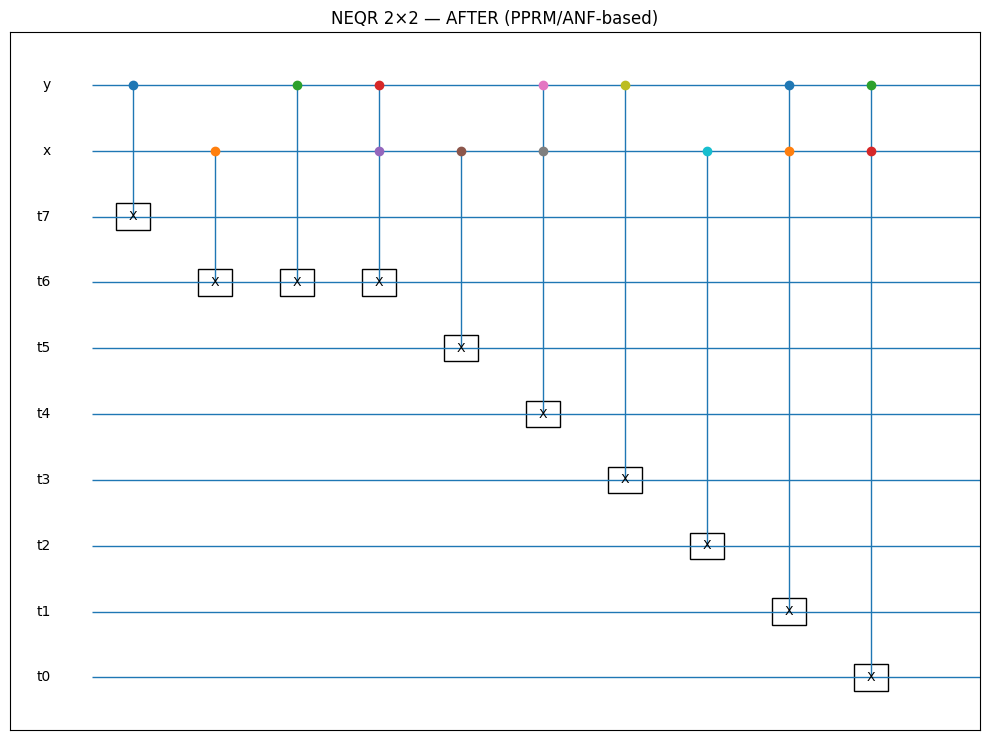

In [4]:
# AFTER (PPRM/ANF-based) — NEQR circuit for 2×2 pixels with values [0, 100, 200, 255]
import matplotlib.pyplot as plt

# ----- Problem setup -----
vals = [0, 100, 200, 255]
bits = [f"{v:08b}" for v in vals]                     # strings b7..b0
a_by_bit = [[int(b[k]) for b in bits] for k in range(8)]  # per k=b7..b0: [f(00),f(01),f(10),f(11)]

# ----- n=2 ANF/PPRM coefficients (order [1, x, y, xy]) -----
def anf_from_truth(a):
    a0, a1, a2, a3 = a
    b0 = a0
    b1 = a0 ^ a1     # x
    b2 = a0 ^ a2     # y
    b3 = a0 ^ a1 ^ a2 ^ a3   # xy
    return [b0, b1, b2, b3]

# ----- Build PPRM gates (positive controls only) -----
def pprm_gates_for_bit(bit_index, b):
    tname = f"t{bit_index}"
    gates = []
    if b[0] == 1:  # constant term
        gates.append({'target': tname, 'controls': []})
    if b[1] == 1:  # x
        gates.append({'target': tname, 'controls': [('x', +1)]})
    if b[2] == 1:  # y
        gates.append({'target': tname, 'controls': [('y', +1)]})
    if b[3] == 1:  # xy
        gates.append({'target': tname, 'controls': [('y', +1), ('x', +1)]})
    return gates

wires = ['y', 'x'] + [f"t{b}" for b in range(7, -1, -1)]
after_gates = []
for k in range(7, -1, -1):
    a = a_by_bit[7 - k]              # truth vector for bit t_k
    bcoef = anf_from_truth(a)        # PPRM/ANF coefficients
    after_gates.extend(pprm_gates_for_bit(k, bcoef))

# ----- Simple drawer (matplotlib) -----
def draw_circuit(wires, gates, title, x_spacing=1.2):
    y_positions = {w: i for i, w in enumerate(wires)}
    H = len(wires)
    W = max(10, int(len(gates) * x_spacing * 0.6))
    fig, ax = plt.subplots(figsize=(W, H * 0.6 + 1.5))

    for i, w in enumerate(wires):
        ax.hlines(H - 1 - i, 0, len(gates) * x_spacing + 1, linewidth=1)
        ax.text(-0.6, H - 1 - i, w, va='center', ha='right')

    for idx, gate in enumerate(gates):
        x0 = 0.6 + idx * x_spacing
        y_t = H - 1 - y_positions[gate['target']]
        box_w, box_h = 0.5, 0.4
        ax.add_patch(plt.Rectangle((x0 - box_w/2, y_t - box_h/2), box_w, box_h, fill=False))
        ax.text(x0, y_t, 'X', ha='center', va='center', fontsize=9)

        ys = [y_t] + [H - 1 - y_positions[w] for (w, _) in gate['controls']]
        ax.vlines(x0, min(ys), max(ys), linewidth=1)

        for (w, pol) in gate['controls']:
            yc = H - 1 - y_positions[w]
            ax.plot([x0], [yc], marker='o', markersize=6)  # only positive controls here

    ax.set_xlim(-1.2, len(gates) * x_spacing + 1)
    ax.set_ylim(-0.8, H - 0.2)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

draw_circuit(wires, after_gates, "NEQR 2×2 — AFTER (PPRM/ANF-based)")
